In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf
import time
from IPython import display

2023-11-10 17:22:24.965881: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 17:22:27.731001: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 17:22:27.731052: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 17:22:27.750828: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 17:22:28.774497: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 17:22:28.777031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Preprocessing
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# Grab only the first 1000 images
train_images = train_images[:1000]
train_labels = train_labels[:1000]

print(train_images.shape)

# Reshape to float 32
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype("float32")

# Set the matrix of train_images to be between 1 and -1
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 6000
BATCH_SIZE = 256

# Turn the matrix into individual elemets
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
# Select random elements only from the first buffer_size elements
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# Total amount of elements being used or smth
train_dataset = train_dataset.batch(BATCH_SIZE)

(1000, 32, 32, 3)


In [26]:
def generate_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def generate_discriminator():
    activation_mode = "relu"

    model = tf.keras.Sequential([
        layers.Conv2D(
            filters=100,
            kernel_size=3,
            activation=activation_mode,
            input_shape=(32, 32, 3)
        ),
        layers.Conv2D(100, 3, activation=activation_mode),
        layers.Dropout(0.4),
        layers.MaxPool2D(),
        layers.Conv2D(100, 3, activation=activation_mode),
        layers.Conv2D(100, 3, activation=activation_mode),
        layers.Dropout(0.4),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(100, activation="tanh"),
        layers.Dropout(0.4),
    ])

    return model

(1, 32, 32, 3)


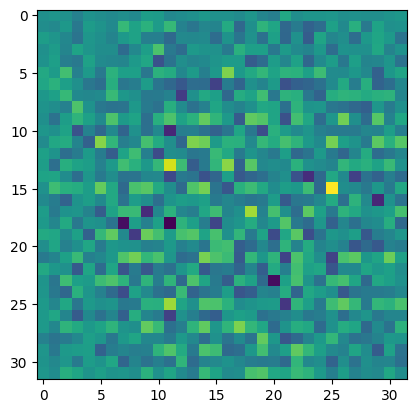

In [27]:
generator = generate_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

print(generated_image.shape)

descriminator = generate_discriminator()
decision = descriminator(generated_image)

In [28]:
# Create our descriminator model and make it do it's decision on the noise
discriminator = generate_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[-3.1423818e-03 -4.0815254e-03 -3.2205856e-03  2.4206580e-03
   6.3303200e-04 -2.0527847e-04  1.4325588e-03 -4.2928718e-03
  -1.0610925e-04 -2.2149072e-03  8.7407872e-04  2.6815184e-04
  -6.3353060e-03 -7.8323361e-04  1.9250208e-04  3.4430681e-03
   2.8444126e-03  2.5575713e-04 -5.4418540e-04 -5.4149092e-03
   1.3654903e-03 -3.3595518e-03 -5.4971984e-05  8.1619876e-04
  -1.9266721e-03  6.4410060e-03 -1.5801513e-03  4.3861773e-03
   3.3747118e-03  7.7829266e-04 -5.1574791e-03  2.7613313e-04
  -4.5274869e-03 -3.8167462e-03  5.1664994e-03  2.8146105e-03
  -1.2249789e-04  5.1903753e-03  1.7921653e-03  1.4326575e-03
   4.5627346e-03 -3.6974803e-03 -4.4949893e-03  2.6449696e-03
   5.3482712e-04  6.0519087e-03 -2.4397619e-04 -3.9231703e-03
   7.3562986e-03 -1.4776696e-03  1.3589733e-03 -2.4925992e-03
  -9.6237112e-04  9.3934924e-04  1.0316804e-03  3.6228443e-03
   2.8509699e-04  1.8055185e-03 -8.0063120e-03 -2.9821433e-03
   1.5908139e-03 -4.2347731e-03 -9.3491655e-03  3.7294085e-

In [29]:
# Cross Entropy Loss YK
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discrimator loss will get the loss of fake and real
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss will get the loss of the fake
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
# Using adam optimizers, maybe try ada after
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


EPOCHS = 10
# Noise dim = amount of noise
noise_dim = 100
num_examples = 16

# Seed for re-using
seed = tf.random.normal([num_examples, noise_dim])

@tf.function
def train_step(images):
    # Generate random values based off of batch size and noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Compute the gradient to gradually improve the model
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Create images using the generator noise
        generated_images = generator(noise, training=True)

        # The real image
        real_output = discriminator(images, training=True)
        # What the generator made
        fake_output = discriminator(generated_images, training=True)

        # How good the generator was
        gen_loss = generator_loss(fake_output)
        # How good the discrimator was
        disc_loss = discriminator_loss(real_output, fake_output)

    # Create gradients based off of their losses
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize the 2 models based off of the results
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
# Pass in model, epochs and seed
def generate_images(model, epoch, seed):
    # Run everything in inference mode
    predictions = model(seed, training=False)

    figure = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, 1+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis("off")

    plt.savefig(f"/epochs_image/image_at_epoch_{epoch}")
    plt.show()

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [33]:
def train(dataset, epochs):

    # Map over each epoch
    for epoch in range(epochs):
        # print(epoch)Get the time for funsy's
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce fun gifs of the images haha
        display.clear_output(wait=True)
        generate_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print(f"Time for epoch {epoch} is {time.time()-start} seconds")

    display.clear_output(wait=True)
    generate_images(generator, epochs + 1, seed)

In [34]:
train(train_dataset, EPOCHS)

2023-11-10 17:28:03.260343: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2023-11-10 17:28:03.376068: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80281600 exceeds 10% of free system memory.
2023-11-10 17:28:03.377536: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80281600 exceeds 10% of free system memory.
2023-11-10 17:28:03.590432: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80281600 exceeds 10% of free system memory.
2023-11-10 17:28:04.098214: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80281600 exceeds 10% of free system memory.
